# EOEPCA+ Use Case: NO2 Tropospheric Content Cloud Filtering - Register Cloud Fraction

# Table of Contents

1. Introduction
1. Get external data: Cloud Fraction
2. Apply STAC Best Practices
3. Save metadata to the EOEPCA Workspace
4. Register metadata to the EOEPCA STAC API
5. Access and process the data

# Introduction

## End-to-End Use Case
An environmental agency wants to create a platform for their employees to analyze earth observation data. The regional focus of the platform is Europe. The agency wants their employees to be able to access all relevant data in one place. There they also analyse and process the data to create value added products they want to publish through the same platform. In this case a NO2 Tropospheric Content Product should be created on a monthly basis. Therefore, NO2 Tropospheric Content and Cloud Cover Data is combined to create cloudfree monthly composites. 

The use case is split into three parts: 

1. E2E External Data Registration Cloud Fraction (this notebook)
2. [E2E External Data Registration NO2]("./08-2 E2E External Data Registration NO2.ipynb")
3. [E2E Process Data Jointly]("./08-3 E2E Process Data Jointly.ipynb")


## What happens in this notebook
In this notebook the STAC Metadata of the Sentinel-5P Inpuls Cloud Fraction Data is pulled from the DLR Geoservice. Only the spatial extent of Europe is requested. The STAC Metadata is adapted to follow STAC Best Practices. Then the adapted metadata is registered to the EOEPCA STAC API. From there the processing building block can be used to process the data.


![end2end_workflow](img/end2end_workflow_cf.png)

`micromamba create -n eoepca_end2end -c conda-forge pystac pystac-client odc odc-stac openeo xarray rioxarray rasterio geopandas pyproj numpy folium shapely pyjwt certifi boto3 python-dotenv pip jupyterlab`

In [1]:
# general
from pystac_client import Client
from odc.stac import stac_load
from pystac import Item, Collection, Catalog, Extent, SpatialExtent, TemporalExtent, Asset
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import certifi

# dataset extraction of time and space
import xarray as xr
import rioxarray
import rasterio
from shapely.geometry import Polygon, mapping

# workspace management
import jwt
import requests
import time
import os
from dotenv import load_dotenv
import urllib3
import json
import boto3

# harvester
from requests import Session
from requests.auth import HTTPBasicAuth

# processing
import openeo
from openeo.local import LocalConnection


Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


<a id="get_external_data"></a>
# Get external data: Cloud Fraction

Get cloud fraction data from the DLR GeoService STAC API.
- S5P Cloud Fraction Inpuls L3: EOC Geoservice Sentinel-5P TROPOMI L3 Daily Composites - Cloud Fraction (CF)
- https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S5P_TROPOMI_L3_P1D_CF_v2

## Request: DLR Geoservice

Request to the DLR Geoservice STAC API asking for the S5P TROPOMI Cloud Fraction data for Europe, from August 2023 to December 2023.

In [2]:
# Handle Geoservice Certificates - et SSL-Cert-Path via Env Var
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['CURL_CA_BUNDLE'] = certifi.where()

In [3]:
url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
catalog = Client.open(url)

In [4]:
collection_id = "S5P_TROPOMI_L3_P1D_CF_v2" # --> full history, new collection; "S5P_TROPOMI_L3_P1D_CF" --> old
bbox = [-10.0, 35.0, 30.0, 70.0]  # Europe
date_time = "2023-08-01T00:00:00Z/2023-12-31T23:59:59Z"

In [5]:
search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    limit=400  # adjust as needed
)

In [6]:
items = list(search.items())

### Check the returned metadata items
Look at the number of items we have received and their information.

In [7]:
print(f"Number of items: {len(items)}")
print(f"First item     : {items[0]}")
print(f"Last item      : {items[-1]}")

Number of items: 154
First item     : <Item id=S5P_DLR_OFFL_01_L3_CF_20231231>
Last item      : <Item id=S5P_DLR_OFFL_01_L3_CF_20230731>


In [8]:
items[0]

<Item id=S5P_DLR_OFFL_01_L3_CF_20231231>

### Check the data values
Load the data and check that it's valid.

In [9]:
ds = stac_load(
    items,
    bands=["cf"],
    crs="EPSG:4326",
    resolution=0.1, # native resolution
    bbox=bbox,
    chunks={"time": 1},
)

In [10]:
ds

<xarray.Dataset> Size: 86MB
Dimensions:      (latitude: 350, longitude: 400, time: 154)
Coordinates:
  * latitude     (latitude) float64 3kB 69.95 69.85 69.75 ... 35.25 35.15 35.05
  * longitude    (longitude) float64 3kB -9.95 -9.85 -9.75 ... 29.75 29.85 29.95
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 1kB 2023-07-31T12:47:29.015500 ... 202...
Data variables:
    cf           (time, latitude, longitude) float32 86MB dask.array<chunksize=(1, 350, 400), meta=np.ndarray>

In [11]:
monthly_mean_cf = ds['cf'].groupby('time.month').median(dim='time')

CPU times: user 10 s, sys: 932 ms, total: 11 s
Wall time: 32.6 s


/dss/dsshome1/06/di38laz/micromamba/envs/eoepca_end2end3/lib/python3.11/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


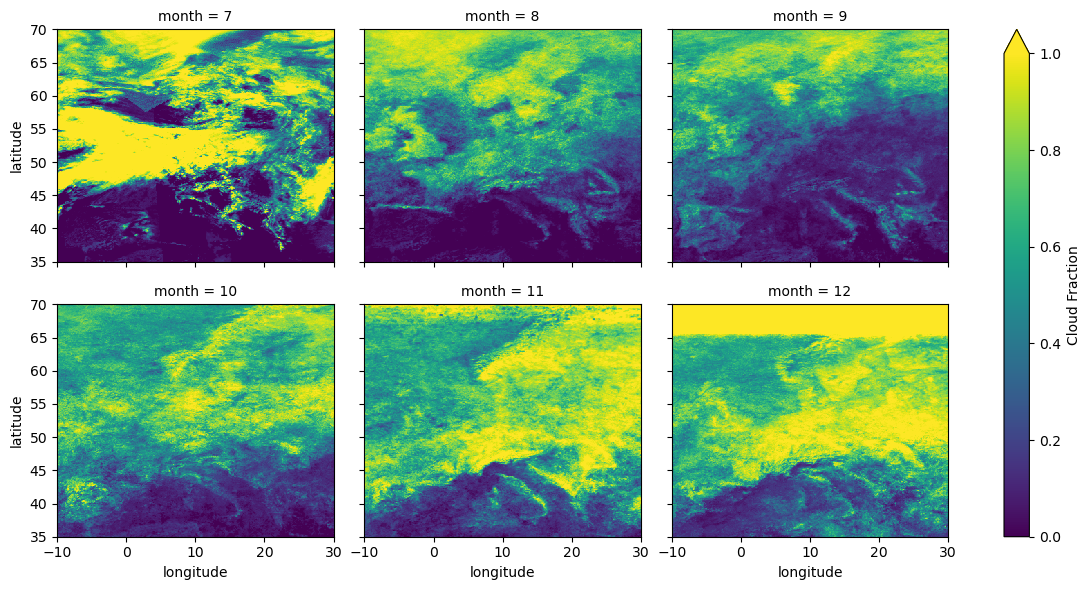

In [12]:
%%time
monthly_mean_cf.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Cloud Fraction"})

# Apply STAC Best Practices

The [**Data Cube Access Building Block**](https://eoepca.readthedocs.io/projects/datacube-access/en/latest/) ensures that data can be transferred from one Building Block to the next.
To ensure proper functioning of the STAC Collection with the STAC software ecosystem collections and items should comply to STAC Best Practices. 
In this case we are dealing with a data cube made up of geotif files. Therefore, we will follow the STAC Best Practices for Data Cubes based on non-data cube generic file formats (under active development).
- [Data Cube from arbitrary files](https://github.com/EOEPCA/datacube-access/blob/main/best_practices/stac_best_practices.md)

More STAC Best Practices can be found here: 
- [Official STAC Best Practices](https://github.com/radiantearth/stac-best-practices)
  - [Item](https://github.com/radiantearth/stac-best-practices/blob/main/best-practices-item.md)
  - [Data Cube Zarr](https://github.com/radiantearth/stac-best-practices/blob/main/best-practices-zarr.md). 

## Adapt to Best Practices

Import pystac to manipulate the STAC metadata.

In [13]:
import pystac
from pystac import Item, Asset, Collection, Catalog, Extent, SpatialExtent, TemporalExtent, Summaries
from pystac.extensions.eo import EOExtension, Band
from pystac.extensions.projection import ProjectionExtension
from pystac.extensions.datacube import SpatialDimension, TemporalDimension, Dimension, DatacubeExtension
from pystac.extensions.raster import RasterExtension
from pystac.extensions.storage import StorageExtension
from pystac.extensions.scientific import ScientificExtension
from pystac.extensions.raster import RasterExtension, RasterBand

### Catalog

Set a name for the catalog (needed for intermediate local saving) and collection .

In [14]:
catalog_id = 's5p-cf-bp-stac-catalog' # adapt to catalog_name
collection_id = 's5p-cf-bp'

Define extensions to be used.

In [15]:
stac_extensions_catalog = [
        # "https://stac-extensions.github.io/authentication/v1.1.0/schema.json"  # --- pending OpenEO inclusion
]

Initialize catalog

In [16]:
catalog = pystac.Catalog(id= catalog_id,
                         description="Root catalog for S5P Cloud Fraction.",
                         title="S5P Cloud Fraction STAC Catalog",
                         stac_extensions=stac_extensions_catalog
                         )


In [17]:
catalog

<Catalog id=s5p-cf-bp-stac-catalog>

### Collection

Get footprint from "new" bbox, as used in the STAC search.

In [18]:
footprint = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]],
    ])
footprint = mapping(footprint) # convert to json polygon notation

Get shape and and transform for the proj extension (important for software to read data directly from STAC). They have to be taken from the loaded data, since the extents have changed!

In [19]:
shape = [ds.sizes["latitude"], ds.sizes["longitude"]] # has to be loaded from data
transform = list(ds.cf.rio.transform()) # [1.0, 0.0, bbox[0], 0.0, -1.0, bbox[3], 0.0, 0.0, 1.0] # hardcode, or take from data. Wasn't in original metadata.
#proj_epsg = int(items[0].properties.get("proj:code").split(":")[1]) # old
proj_epsg = int(items[0].properties.get("proj:epsg")) # new 

Get minimum and maximum times from the returned items.

In [20]:
datetimes = [
    item.datetime
    for item in items
    if item.datetime is not None
]

start_time = min(datetimes)
end_time = max(datetimes)
temporal_extent = [
    (start_time.isoformat(), end_time.isoformat())
]

now_time = datetime.now(timezone.utc).isoformat()

Define extensions to be used.

In [21]:
stac_extensions_collection = [
    "https://stac-extensions.github.io/item-assets/v1.0.0/schema.json",
    "https://stac-extensions.github.io/eo/v1.1.0/schema.json",
    "https://stac-extensions.github.io/projection/v2.0.0/schema.json",
    "https://stac-extensions.github.io/raster/v1.1.0/schema.json",
    # "https://stac-extensions.github.io/datacube/v2.3.0/schema.json", # --- datacube schema does not allow validation on collection level, but can be used
    # "https://stac-extensions.github.io/storage/v2.0.0/schema.json"  # --- pending OpenEO inclusion
]

Initialize the collection and add information accoring to best practices.

In [22]:
collection = Collection(
    id=collection_id,
    title="Sentinel-5P Cloud Fraction", # maybe add collection_id
    description="Sentinel-5P Cloud Fraction L3 data (Aug-Dec 2023)",
    stac_extensions=stac_extensions_collection,
    license="CC-BY-4.0",
    extent=Extent(
        spatial=SpatialExtent(bbox),
        temporal=TemporalExtent(intervals=[start_time, end_time])
    )
)

# Add creation time of the metadata and possibly the updated time
collection.created = now_time #datetime.now(timezone.utc) # strftime("%Y-%m-%dT%H:%M:%S.%fZ")
# collection.updated = now_time #datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%S.%fZ") # This would become relevant when updating the collection.

# Add a thumbnail as asset
collection.add_asset(
    "thumbnail",
    Asset(
        href="https://geoservice.dlr.de/catalogue/srv/api/records/587a076a-0cb6-494b-8f87-3fc8cfea8b22/attachments/atmosphere-S5P_TROPOMI_L3_P1D_CF_ql_s.jpg",
        media_type="image/png",
        title="Cloud Fraction Thumbnail",
        roles=["thumbnail"]
    )
)

# Add general information in the summaries. Use eo and proj extensions!
collection.summaries = Summaries(
    summaries={
        "datetime": {
            "min": start_time.isoformat(),
            "max": end_time.isoformat(),
        },
        "platform": [items[0].properties.get("platform")],
        "constellation": [items[0].properties.get("constellation")],
        "instruments": [items[0].properties.get("instruments")],
        "eo:cloud_cover": [items[0].properties.get("eo:cloud_cover")],
        "eo:bands": [Band.create(
            name="cf",
            description="Radiometric cloud fraction (Sentinel-5P)",
            common_name="cloud_fraction"
        ).to_dict()],
        "proj:epsg": [proj_epsg], # proj:code in original metadata has to be only the code for odc.stac compatability
        "proj:transform": transform
    }
)

collection.extra_fields["item_assets"] = {
    "cf": {
        "type": "image/tiff; application=geotiff",
        "title": "Cloud Fraction",
        "description": "Radiometric cloud fraction (Sentinel-5P)",
        "roles": ["data"]
    }
}

# Datacube extension on collection
datacube_ext = {"cube:dimensions": {
    "x": {
      "type": "spatial",
      "axis": "x",
      "extent": [bbox[0], bbox[2]],
      "reference_system": proj_epsg
    },
    "y": {
      "type": "spatial",
      "axis": "y",
      "extent": [bbox[1], bbox[3]],
      "reference_system": proj_epsg
    },
    "time": {
      "type": "temporal",
      "extent": temporal_extent,
      "step": "P5D"
    },
    "band": {
        "type": "bands",
        "values": ["cf"]
    }
  },
}
collection.extra_fields.update(datacube_ext)

In [23]:
collection

<Collection id=s5p-cf-bp>

### Items

Define extensions to be used.

In [24]:
stac_extensions_item = [
    "https://stac-extensions.github.io/eo/v1.1.0/schema.json",
    "https://stac-extensions.github.io/projection/v2.0.0/schema.json",
    "https://stac-extensions.github.io/raster/v1.1.0/schema.json",
    "https://stac-extensions.github.io/storage/v2.0.0/schema.json",
    "https://stac-extensions.github.io/sentinel-5p/v0.2.0/schema.json"
]

Adapt item information to Best Practices.

In [25]:
new_items = []
for old_item in items:
    new_item = Item(
        id=old_item.id,
        geometry=footprint,
        bbox=bbox,
        datetime=old_item.datetime,
        properties={
            k: v
            for k, v in old_item.properties.items()
            if k not in ["eo:bands", "proj:code"]
        },
    )

    # adapt proj info on properties level
    new_item.properties["proj:bbox"] = bbox
    new_item.properties["proj:shape"] = shape

    # adapt assets
    for key, asset in old_item.assets.items():
        if key == "cf":
            new_asset = Asset(
                href=asset.href,
                media_type=asset.media_type,
                roles=asset.roles,
                title=asset.title,
                description=asset.description,
            )
            new_item.add_asset("cf", new_asset)

            proj = ProjectionExtension.ext(new_asset, add_if_missing=True) # Attach projection extension correctly
            #proj_code = asset.extra_fields.get('proj:code', '') # old # Convert 'EPSG:4326' format to numeric EPSG code, for ODC STAC compatibility
            #proj.epsg = int(proj_code.split(":")[1]) # old
            proj.epsg = asset.extra_fields.get('proj:epsg', '')
            proj.shape = shape
            proj.transform = transform

    # Normalize other properties
    if new_item.properties.get("license") == "CC-BY 4.0":
        new_item.properties["license"] = "CC-BY-4.0"
    if isinstance(new_item.properties.get("instruments"), str):
        new_item.properties["instruments"] = [new_item.properties["instruments"]]

    new_item.properties["updated"] = now_time

    collection.add_item(new_item)
    new_items.append(new_item)


In [26]:
new_items[0]

<Item id=S5P_DLR_OFFL_01_L3_CF_20231231>

### Finalize

In [27]:
catalog.add_child(collection)
catalog.normalize_hrefs(f"./{catalog_id}")
catalog.normalize_and_save(catalog_id, catalog_type="SELF_CONTAINED") # type: ignore

In [28]:
print(f"Catalog saved to: {catalog_id}")
print(f"Number of items in collection: {len(list(collection.get_all_items()))}")

Catalog saved to: s5p-cf-bp-stac-catalog
Number of items in collection: 154


## Validate the saved catalog
Before uploading our files we validate the collection and each individual item.

In [29]:
catalog = Catalog.from_file(f"{catalog_id}/catalog.json")
print(f"Validating catalog: {catalog.validate()}")

collection = catalog.get_child(collection_id) 
print(f"Validating collection: {collection.validate()}") # type: ignore

print("Validating items")
items = list(collection.get_all_items()) # type: ignore
for item in items:
    try:
        item.validate()
    except Exception as e:
        print(f"Failed Items: {item.id, e}")

Validating catalog: ['https://schemas.stacspec.org/v1.0.0/catalog-spec/json-schema/catalog.json']
Validating collection: ['https://schemas.stacspec.org/v1.0.0/collection-spec/json-schema/collection.json', 'https://stac-extensions.github.io/item-assets/v1.0.0/schema.json', 'https://stac-extensions.github.io/eo/v1.1.0/schema.json', 'https://stac-extensions.github.io/projection/v2.0.0/schema.json', 'https://stac-extensions.github.io/raster/v1.1.0/schema.json']
Validating items


# Save metadata to the EOEPCA Workspace

The [**Workspace BB**](https://eoepca.readthedocs.io/projects/workspace/en/latest/) is used to upload the json files to our workspace `ws-eric`.

## Workplace Setup definitions

These are our user information.

In [30]:
owner = "eric"
password = "changeme"
ws_name = "ws-eric"

The workspace configuration needs some variables that are kept in a `.env` file. Here's an [example](https://github.com/EOEPCA/workspace/blob/main/.env.sample).

In [31]:
load_dotenv()

True

In [32]:
# Config
realm = os.getenv("REALM")
base_domain = os.getenv("BASE_DOMAIN")
keycloak_endpoint = os.getenv("KEYCLOAK_ENDPOINT")
default_scope = os.getenv("DEFAULT_SCOPE")
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

issuer = f"{keycloak_endpoint}/realms/{realm}"
token_endpoint = f"{issuer}/protocol/openid-connect/token"
device_authorization_endpoint = f"{issuer}/protocol/openid-connect/auth/device"
userinfo_endpoint = f"{issuer}/protocol/openid-connect/userinfo"

workspace_api_endpoint = f'https://workspace-api.{base_domain}/workspaces'

Define functions to interact with workspace.

In [33]:
# Helper function to get token via device flow
def token_via_device_flow(
    client_id: str,
    client_secret: str | None = None,
    scope: str = "openid profile email",
    poll_interval: int | None = None,
    timeout: int = 600
):
    da_resp = requests.post(
        device_authorization_endpoint,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={
            "client_id": client_id,
            **({"client_secret": client_secret} if client_secret else {}),
            "scope": scope,
        },
        timeout=30,
    )
    da_resp.raise_for_status()
    da = da_resp.json()

    device_code = da["device_code"]
    user_code = da["user_code"]
    verification_uri = da["verification_uri"]
    verification_uri_complete = da.get("verification_uri_complete")
    interval = poll_interval or da.get("interval", 5)
    expires_in = da.get("expires_in", timeout)

    print(f"Open: {verification_uri}")
    print(f"Enter code: {user_code}")
    if verification_uri_complete:
        print(f"(Or open directly): {verification_uri_complete}")

    start = time.time()
    data = {
        "grant_type": "urn:ietf:params:oauth:grant-type:device_code",
        "device_code": device_code,
        "client_id": client_id,
        **({"client_secret": client_secret} if client_secret else {}),
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    while True:
        if time.time() - start > min(timeout, expires_in):
            raise TimeoutError("Device authorization timed out.")
        resp = requests.post(token_endpoint, headers=headers, data=data, timeout=30)
        if resp.ok:
            tok = resp.json()
            break
        try:
            err = resp.json().get("error")
        except Exception:
            resp.raise_for_status()
        if err == "authorization_pending":
            time.sleep(interval)
            continue
        elif err == "slow_down":
            interval += 5
            time.sleep(interval)
            continue
        elif err in ("access_denied", "expired_token", "invalid_grant"):
            raise RuntimeError(f"Device flow failed: {err}")
        else:
            resp.raise_for_status()

    access_token = tok.get("access_token")
    decoded = jwt.decode(access_token, options={"verify_signature": False, "verify_aud": False})

    print("\n--- Decoded Access Token ---")
    for k, v in decoded.items():
        print(f"{k}: {v}")

    ra = decoded.get("resource_access", {}) or {}
    roles_wsapi = ra.get(client_id, {}).get("roles", []) or []
    is_operator = "admin" in roles_wsapi

    workspaces = []
    for client, meta in ra.items():
        roles = (meta or {}).get("roles", []) or []
        if client.startswith("ws-") and "ws_access" in roles:
            workspaces.append(client)

    print("\n--- Access Summary ---")
    if is_operator:
        print("user is OPERATOR")
    elif workspaces:
        print(f"user has WORKSPACE ACCESS: {', '.join(sorted(workspaces))}")
    else:
        print("user is neither OPERATOR nor has WORKSPACE ACCESS")

    return access_token, is_operator, sorted(workspaces)

## Workplace Setup interactive

We retrieve a token via device flow that allows us to interact with our workspace. You will be asked to authenticate.

In [34]:
token, is_operator, workspaces = token_via_device_flow(client_id=client_id, client_secret=client_secret)

Open: https://iam-auth.develop.eoepca.org/realms/eoepca/device
Enter code: XFMT-XDLW
(Or open directly): https://iam-auth.develop.eoepca.org/realms/eoepca/device?user_code=XFMT-XDLW

--- Decoded Access Token ---
exp: 1768841178
iat: 1768840878
auth_time: 1768840557
jti: 09b0727c-fbf0-4b34-82af-b70abfb3c32a
iss: https://iam-auth.develop.eoepca.org/realms/eoepca
aud: ['ws-eric', 'zoo', 'account']
sub: 3730a2a4-bee4-4ec6-b0cf-c70e866da380
typ: Bearer
azp: workspace-api
sid: 070b7106-8794-48c3-82b9-4928984eaa45
acr: 0
allowed-origins: ['*']
realm_access: {'roles': ['offline_access', 'default-roles-eoepca', 'uma_authorization']}
resource_access: {'ws-eric': {'roles': ['ws_admin', 'ws_access']}, 'zoo': {'roles': ['uma_protection']}, 'account': {'roles': ['manage-account', 'view-consent', 'manage-account-links', 'manage-consent', 'view-profile']}}
scope: openid profile email
email_verified: True
name: Eric E
groups: ['/ws-eric', '/ws-eric-admin']
preferred_username: eric
given_name: Eric
fami

Let's check if we can access the workspace.

In [35]:
assert ws_name in workspaces, f"User does not have access to workspace {ws_name}"

Retrieve information from the workspace. And check status.

In [36]:
headers = {
    'Authorization': 'bearer ' + token
}
url = f"{workspace_api_endpoint}/{ws_name}"
print(f"HTTP GET {url}")

response = requests.get(url, headers=headers)
assert response.status_code == 200

HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-eric


Extract relevant information for storage.

In [37]:
workspace_data = response.json()
bucket_name = workspace_data["storage"]["credentials"]["bucketname"]
s3_access = workspace_data["storage"]["credentials"]["access"]
s3_secret = workspace_data["storage"]["credentials"]["secret"]
s3_endpoint = workspace_data["storage"]["credentials"]["endpoint"]

Connect to the workspace via s3.

In [38]:
session = boto3.session.Session()
s3resource = session.resource('s3', aws_access_key_id=s3_access, aws_secret_access_key=s3_secret, endpoint_url=s3_endpoint)

In [39]:
s3_folder_prefix = f"end2end/{catalog_id}/"

## Upload

Recursively upload all files (the catalog, collection and items)

In [42]:
uploaded_count = 0

for root, dirs, files in os.walk(catalog_id):
    for file in files:
        local_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_path, catalog_id)
        s3_key = os.path.join(s3_folder_prefix, relative_path).replace("\\", "/")

        try:
            obj = s3resource.Object(bucket_name, s3_key)
            with open(local_path, 'rb') as data:
                result = obj.put(Body=data)

            status_code = result["ResponseMetadata"]["HTTPStatusCode"]
            if status_code != 200:
                raise RuntimeError(
                    f"Upload failed for {s3_key} (HTTP {status_code})"
                )

            uploaded_count += 1

            # single-line progress update
            print(
                f"Uploading to {s3_key}: {uploaded_count} files uploaded",
                end="\r",
                flush=True,
            )

        except Exception as e:
            # Move to new line before error
            print()
            raise RuntimeError(
                f"Error uploading {s3_key} after {uploaded_count} successful uploads"
            ) from e

# New line so summary doesn't overwrite progress
print()
print(
    f"Successfully uploaded {uploaded_count} files to path {s3_folder_prefix}"
)


Uploading to end2end/s5p-cf-bp-stac-catalog/s5p-cf-bp/S5P_DLR_OFFL_01_L3_CF_20231030/S5P_DLR_OFFL_01_L3_CF_20231030.json: 158 files uploadedpoint.json: 62 files uploaded
Successfully uploaded 158 files to path end2end/s5p-cf-bp-stac-catalog/


## Check that files are available
Check that files are available here (click on Datalab): 

In [43]:
print(f"{workspace_api_endpoint}/{ws_name}")

https://workspace-api.develop.eoepca.org/workspaces/ws-eric


# Register metadata to the EOEPCA STAC API

The [**Registration BB - Harvester**]() adds the catalogue to EOEPCA STAC API.

## Harvester Setup

In [44]:
# Setup connection to Flowable API
flowable_base_url = "https://registration-harvester-api.develop.eoepca.org/flowable-rest"
flowable_rest_user = "eoepca"
flowable_rest_pw = "eoepca"
flowable_session = Session()
flowable_session.auth = HTTPBasicAuth(flowable_rest_user, flowable_rest_pw)


In [45]:
url = f"{flowable_base_url}/service/repository/process-definitions"
print(f"GET {url}")
response = flowable_session.get(url)
processes = response.json()["data"]
if len(processes) == 0:
    print("No workflow definitions")
else:
    for idx, process in enumerate(processes, 1):
        print("%-2s %-28s version: %-5s id: %s" % (idx, process['name'], process['version'], process['id']))
        if process["name"] == "STAC Publish":
            stac_processId = process["id"]

GET https://registration-harvester-api.develop.eoepca.org/flowable-rest/service/repository/process-definitions
1  Create timers process        version: 1     id: createTimersProcess:1:6ff96f0e-ae80-11f0-b640-d2eb55003a74
2  Famous One Task Process      version: 1     id: oneTaskProcess:1:6ff96f0d-ae80-11f0-b640-d2eb55003a74
3  Fix system failure           version: 1     id: fixSystemFailure:1:6ff96f0a-ae80-11f0-b640-d2eb55003a74
4  Helpdesk process             version: 1     id: escalationExample:1:6ff96f0c-ae80-11f0-b640-d2eb55003a74
5  Review sales lead            version: 1     id: reviewSaledLead:1:6ff96f0b-ae80-11f0-b640-d2eb55003a74
6  STAC Publish                 version: 1     id: stacPublish:1:201803f1-7840-11f0-b011-7ed8fc866c09
7  Vacation request             version: 1     id: vacationRequest:1:6ff884a9-ae80-11f0-b640-d2eb55003a74


In [46]:
variables = [
    {
        "name": "stac_catalog_source",
        "value": f"s3://ws-eric/{s3_folder_prefix}catalog.json" # "s3://ws-eric/end2end/s5p-bp-stac-catalog/catalog.json"
    },
    {
        "name": "s3_endpoint_url",
        "value": s3_endpoint
    },
    {
        "name": "s3_access_key",
        "value": s3_access
    },
    {
        "name": "s3_secret_key",
        "value": s3_secret 
    }
]
# print(json.dumps(variables, indent=4))


## Start the Harvester Workflow

In [52]:
# Create HTTP request to start the workflow
body = {}
body["processDefinitionId"] = stac_processId # "stacPublish:1:201803f1-7840-11f0-b011-7ed8fc866c09"
body["variables"] = variables
response = flowable_session.post(url=f"{flowable_base_url}/service/runtime/process-instances", json=body)
print(f'Flowable session response code: {response.status_code}')
print(f'Created process instance at {response.json()["url"]}')


Flowable session response code: 201
Created process instance at https://registration-harvester-api.develop.eoepca.org/flowable-rest/service/runtime/process-instances/ee11fe87-f2e3-11f0-a01a-d2eb55003a74


### Monitor the progress

Check the monitoring dashboard: https://monitoring.develop.eoepca.org/ (*Explore, change to Loki in dropdown, label filters "container", "registration-harvester-worker-stac", select timeframe, run query (blue button)*) 

### Check that the data is registered

Check the STAC Collection at the STAC API from the [**Data Access Buiding Block**](https://eoepca.readthedocs.io/projects/data-access/en/latest/).

In [59]:
eoepca_stac_url = "https://eoapi.develop.eoepca.org/stac/collections/"
print(f"{eoepca_stac_url}{collection_id}")

https://eoapi.develop.eoepca.org/stac/collections/s5p-cf-bp


Or visually via the STAC Browser.

In [60]:
eoepca_stac_browser_url = "https://radiantearth.github.io/stac-browser/#/external/eoapi.develop.eoepca.org/stac/collections/"
print(f"{eoepca_stac_browser_url}{collection_id}")

https://radiantearth.github.io/stac-browser/#/external/eoapi.develop.eoepca.org/stac/collections/s5p-cf-bp


# Access and process the data via Pangeo (ODC Stac/xarray)
We're ssing ODC STAC to load the data into the working environment to make sure everything worked as planned.

In [ ]:
url = "https://eoapi.develop.eoepca.org/stac"
catalog = Client.open(url)
#https://eoapi.develop.eoepca.org/stac/collections/s5p-bp-cf-v3
#https://eoapi.develop.eoepca.org/stac/collections/s5p-cf-bp

bbox = [-10.0, 35.0, 30.0, 70.0]  # Europe
date_time = "2023-08-01T00:00:00Z/2023-12-31T23:59:59Z"

search = catalog.search(
    collections=[collection_id],
    bbox=bbox,
    datetime=date_time,
    limit=400  
)

items = list(search.items())

ds = stac_load(
    items,
    #bands=["CF"], 
    crs="EPSG:4326",
    resolution=0.1,
    bbox=bbox,
    chunks={"time": 1} 
)

monthly_mean_cf = ds['cf'].groupby('time.month').median(dim='time')

monthly_mean_cf

/dss/dsshome1/06/di38laz/micromamba/envs/eoepca_end2end3/lib/python3.11/site-packages/dask/_task_spec.py:758: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


CPU times: user 4.14 s, sys: 629 ms, total: 4.77 s
Wall time: 25.3 s


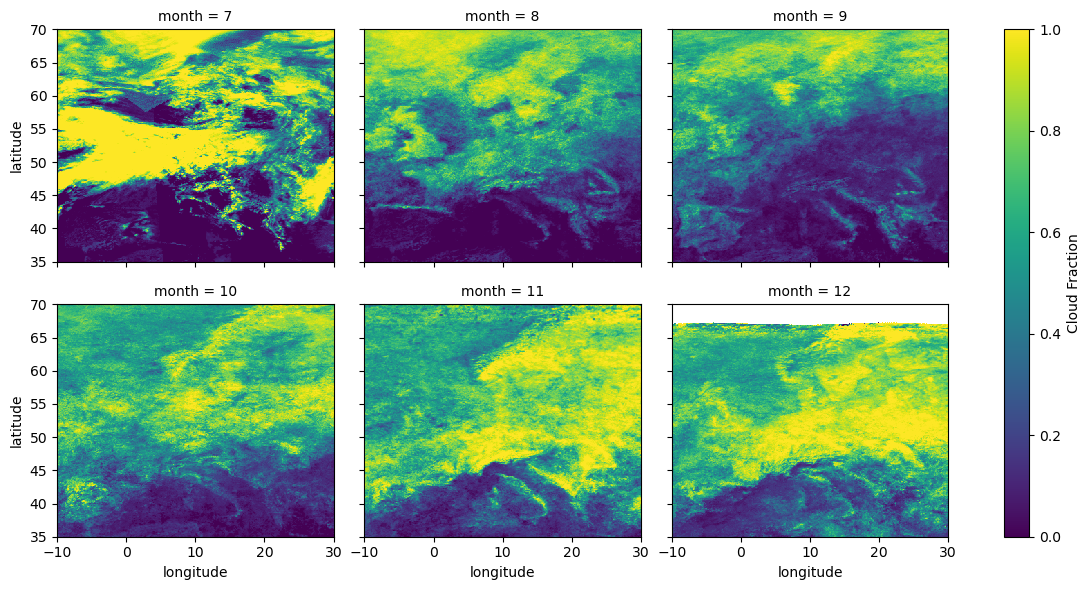

In [48]:
%%time
monthly_mean_cf.plot(col="month",
    col_wrap=3,
    cmap="viridis",
    vmin=0,
    vmax=1,
    figsize=(12, 6),
    cbar_kwargs={"label": "Cloud Fraction"})

# Next Steps
The Cloud Fraction data is available and usable in the EOEPCA STAC API now and it is verified that it can be loaded and used. 
In the following steps we will:
- **[E2E External Data Registration NO2]("./08-2 E2E External Data Registration NO2.ipynb")**: Get S5P NO2 Tropospheric Content and apply the same process to make it available within EOEPCA.
- **[E2E Process Data Jointly]("./08-3 E2E Process Data Jointly.ipynb")**: Use the Processing Building Block to access and process both datasets together, creating monthly cloud filtered NO2 composites. 